# 中证500ETF期权策略分析

本笔记本用于分析我们的期权策略:背对策略，以500etf为标的

In [1]:
# 导入必要的库
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import sys
import os
from dotenv import load_dotenv

# 加在项目中的.env配置 tushare的token之类的配置文件都可以放在里面
load_dotenv()

# 设置绘图风格
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# 添加项目根目录到路径
sys.path.append('..')

# 导入自定义模块 回测模块的engin 和 数据模块的data_fetcher
from data.data_fetcher import DataFetcher

import matplotlib.font_manager as fm

# 获取所有可用字体
# fonts = fm.findSystemFonts()
# for font in fonts:
#     print(fm.FontProperties(fname=font).get_name())

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据准备

首先，我们需要获取中证500ETF和相关期权的数据。如果数据已经存在，我们将直接加载；否则，我们将从Tushare获取数据。

In [2]:
# 定义标的种类和日期范围
start_date = '20240101'
end_date = '20241231'
# 标的映射 500 1000 为对应的中证etf
etf_type = '500'
exchange = 'SSE'

fetcher = DataFetcher()

etf_data, merged_opt_data = fetcher.prepare_backtest_data_origin(start_date, end_date ,etf_type, exchange)

文件/Users/griffith/IdeaProjects/py3/backtraderOption/data/dataHelper/etc_specific/etf_specific_500ETF_20240101_20241231.csv已存在
文件/Users/griffith/IdeaProjects/py3/backtraderOption/data/dataHelper/opt_basic/SSE/opt_basic_SSE_20240101_20241231.csv已存在
文件/Users/griffith/IdeaProjects/py3/backtraderOption/data/dataHelper/opt_specific/SSE/opt_specific_500ETF_SSE_20240101_20241231.csv已存在
合并文件路径: /Users/griffith/IdeaProjects/py3/backtraderOption/data/dataHelper/opt_merged/SSE/opt_merged_500ETF_SSE_20240101_20241231.csv
文件/Users/griffith/IdeaProjects/py3/backtraderOption/data/dataHelper/opt_merged/SSE/opt_merged_500ETF_SSE_20240101_20241231.csv已存在


## 2. 查看数据

让我们先看看ETF和期权数据的基本情况。

In [3]:
# 加载ETF数据
etf_data['trade_date'] = pd.to_datetime(etf_data['trade_date'])

# 显示ETF数据基本信息
print("ETF数据基本信息：")
print(f"数据时间范围：{etf_data['trade_date'].min()} 至 {etf_data['trade_date'].max()}")
print(f"交易日数量：{len(etf_data)}")
print("\n前5行数据：")
etf_data.head()

ETF数据基本信息：
数据时间范围：2024-01-02 00:00:00 至 2024-12-31 00:00:00
交易日数量：242

前5行数据：


,ts_code,trade_date,open,high,low,close,vol,amount
0,510500.SH,2024-01-02,5.524,5.530,5.492,5.497,3092572.47,1705665.321
1,510500.SH,2024-01-03,5.490,5.517,5.461,5.490,2255497.47,1238302.777
2,510500.SH,2024-01-04,5.491,5.495,5.417,5.446,2747555.34,1495540.700
3,510500.SH,2024-01-05,5.438,5.463,5.356,5.376,2031987.30,1099041.995
4,510500.SH,2024-01-08,5.361,5.364,5.248,5.250,2922712.27,1547033.096


In [4]:
# 加载期权数据
merged_opt_data['trade_date'] = pd.to_datetime(merged_opt_data['trade_date'])
merged_opt_data['maturity_date'] = pd.to_datetime(merged_opt_data['maturity_date'])
merged_opt_data['list_date'] = pd.to_datetime(merged_opt_data['list_date'])
merged_opt_data['delist_date'] = pd.to_datetime(merged_opt_data['delist_date'])

# 显示期权数据基本信息
print("期权数据基本信息：")
print(f"期权合约数量：{merged_opt_data['ts_code'].nunique()}")
print(f"看涨期权数量：{merged_opt_data[merged_opt_data['call_put'] == 'C']['ts_code'].nunique()}")
print(f"看跌期权数量：{merged_opt_data[merged_opt_data['call_put'] == 'P']['ts_code'].nunique()}")
print("\n前5行数据：")
merged_opt_data.head()

期权数据基本信息：
期权合约数量：374
看涨期权数量：187
看跌期权数量：187

前5行数据：


,ts_code,trade_date,pre_settle,pre_close,open,high,low,close,settle,vol,amount,name,opt_code,opt_type,call_put,exercise_price,maturity_date,list_date,delist_date
0,10006713.SH,2024-01-22,0.5079,NaN,0.4662,0.4732,0.1689,0.1851,0.2700,792.0,198.4148,南方中证500ETF期权2401认购4.60,OP510500.SH,ETF期权,C,4.6,1970-01-01 00:00:00.020240124,1970-01-01 00:00:00.020240122,1970-01-01 00:00:00.020240124
1,10006713.SH,2024-01-23,0.2700,0.1851,0.1955,0.3741,0.1813,0.3233,0.3480,1234.0,331.2357,南方中证500ETF期权2401认购4.60,OP510500.SH,ETF期权,C,4.6,1970-01-01 00:00:00.020240124,1970-01-01 00:00:00.020240122,1970-01-01 00:00:00.020240124
2,10006713.SH,2024-01-24,0.3480,0.3233,0.3343,0.4166,0.2319,0.4014,0.4180,901.0,273.5391,南方中证500ETF期权2401认购4.60,OP510500.SH,ETF期权,C,4.6,1970-01-01 00:00:00.020240124,1970-01-01 00:00:00.020240122,1970-01-01 00:00:00.020240124
3,10006714.SH,2024-01-22,0.0001,NaN,0.0002,0.0190,0.0002,0.0103,0.0103,16955.0,90.9386,南方中证500ETF期权2401认沽4.60,OP510500.SH,ETF期权,P,4.6,1970-01-01 00:00:00.020240124,1970-01-01 00:00:00.020240122,1970-01-01 00:00:00.020240124
4,10006714.SH,2024-01-23,0.0103,0.0103,0.0098,0.0159,0.0001,0.0002,0.0002,18266.0,101.3022,南方中证500ETF期权2401认沽4.60,OP510500.SH,ETF期权,P,4.6,1970-01-01 00:00:00.020240124,1970-01-01 00:00:00.020240122,1970-01-01 00:00:00.020240124


## 3. 可视化ETF价格走势

让我们绘制中证500ETF在回测期间的价格走势图。

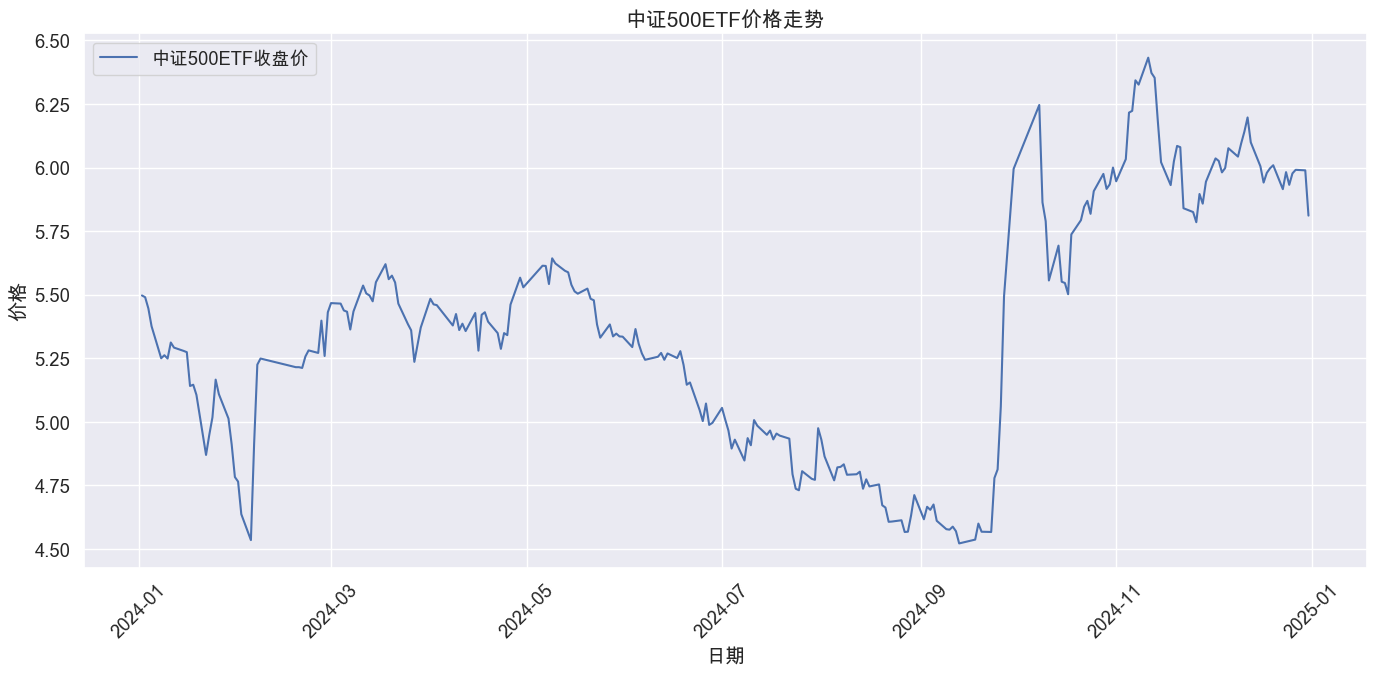

In [5]:
plt.figure(figsize=(14, 7))

# 绘制ETF收盘价走势
plt.plot(etf_data['trade_date'], etf_data['close'], label='中证500ETF收盘价')

# 添加标题和标签
plt.title('中证500ETF价格走势', fontsize=15)
plt.xlabel('日期')
plt.ylabel('价格')
plt.grid(True)
plt.legend()

# 优化x轴日期显示
plt.xticks(rotation=45)
plt.tight_layout()


plt.show()

## 4. 运行策略回测

现在，我们将运行我们的期权策略回测，并分析结果。

In [6]:
from scripts.option.strategies.LongETF_ShortCall_Contrast import LongETFShortCallContrastStrategy

# 初始化策略
strategy = LongETFShortCallContrastStrategy(
    etf_data = etf_data,
    option_data = merged_opt_data,
    initial_stock_capital = 1000000,
    initial_option_capital = 200000,
)

# 运行回测
results = strategy.run_backtest()


# for row in results[:500]:
#     print(row)

## 5. 分析回测结果

让我们分析回测结果，包括收益率、交易统计等。

In [7]:
# 计算关键指标
for row in results[:500]:
    print(row)

{'date': Timestamp('2024-01-02 00:00:00'), 'market_value': 999997.749, 'profit': 0.0, 'profit_rate': 0.0, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-01-03 00:00:00'), 'market_value': 998724.3300000001, 'profit': -1273.418999999878, 'profit_rate': -0.0012734218664724995, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-01-04 00:00:00'), 'market_value': 990719.982, 'profit': -9277.766999999993, 'profit_rate': -0.00927778788430052, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-01-05 00:00:00'), 'market_value': 977985.792, 'profit': -22011.956999999937, 'profit_rate': -0.02201200654902668, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-01-08 00:00:00'), 'market_value': 955064.25, 'profit': -44933.49899999995, 'profit_rate': -0.04493360014553388, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-01-09 00:00:00'), 'market_value': 957247.254, 'profit': -42750.494999999995, 'profit_rate': -0.04275059123158086, 'cash': 2.2510000000474975}
{'date': Timestamp('2024-0

## 6. 可视化交易结果

让我们绘制交易结果的可视化图表。

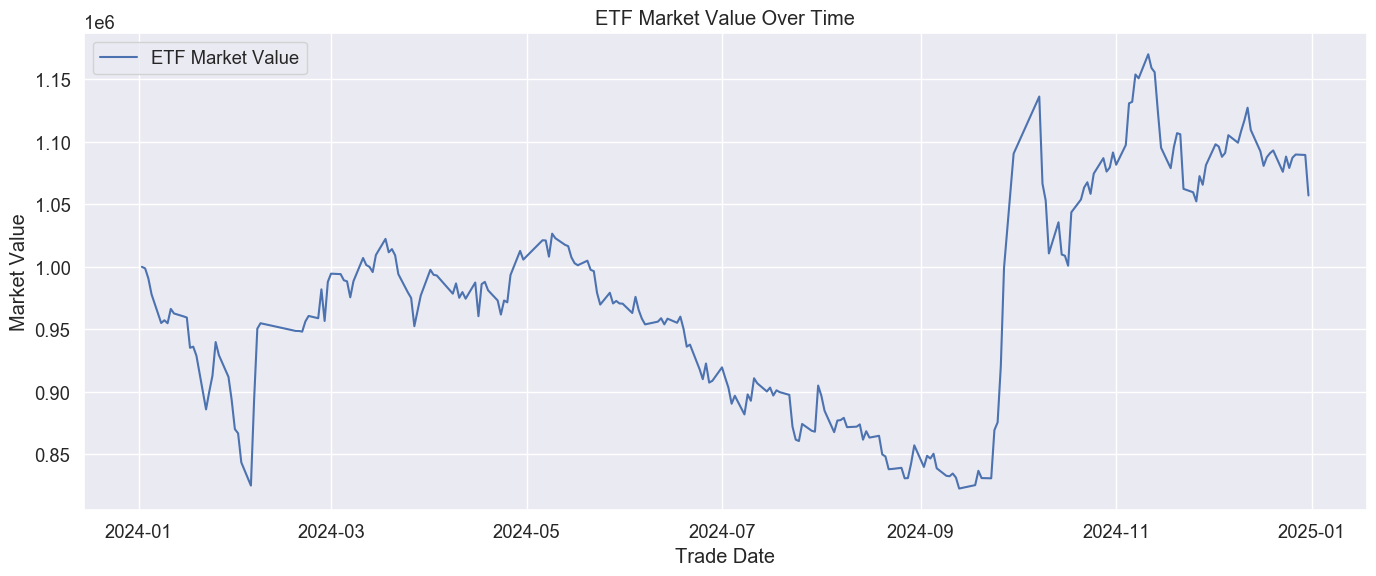

In [8]:
results_df = pd.DataFrame(results)

# 如果date不是datetime类型，转为datetime
if not pd.api.types.is_datetime64_any_dtype(results_df['date']):
    results_df['date'] = pd.to_datetime(results_df['date'])

# 绘制交易日-市值曲线
plt.figure(figsize=(14, 6))
plt.plot(results_df['date'], results_df['market_value'], label='ETF Market Value')
plt.xlabel('Trade Date')
plt.ylabel('Market Value')
plt.title('ETF Market Value Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()